http://rebound.readthedocs.io/en/latest/ipython/Horizons.html

# Saturn

In [1]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "saturn.bin"
#try:
    #sim = rebound.Simulation.from_file("../binaries/"+filename)
#except:
date = "2017-06-04 05:00" # barycentric dynamical time
#grand finale: Sept. 15: Final signal received on Earth at 12:08 p.m. UTC (5:08 a.m. PDT)
#Start of final orbit Apoapse Sep 12 5:37 a.m.UTC 10:37 p.m. PDT
sim = rebound.Simulation()
sim.add("Saturn", date=date)  #sim.add("NAME=Saturn", date=date) 
sim.add("Mimas")
sim.add("Enceladus")
sim.add("Tethys")
sim.add("Dione")
sim.add("Rhea")
sim.add("Titan")
sim.add("Iapetus")
    
sim.move_to_com()
sim.save("../binaries/"+filename)


Searching NASA Horizons for 'NAME=Saturn'... 

Exception: Error while trying to find object.

# Arbitrary System

In [8]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
import random
filename = "newsystem.bin"

sim = rebound.Simulation()
sim.add(m=1.)  #1 Solar mass
a1=1.
sim.add(m=1e-6, a=a1, e=0., inc=0., theta=2.*np.pi*np.random.rand())
a2=a1*(3./2.)**(-2./3)  #semi-major axis of a perfect 5th above planet 1
sim.add(m=1e-6, a=a2, theta=2.*np.pi*np.random.rand())
a3=a2*(4./3.)**(-2./3)  #semi-major axis 4th above planet 2 (=a1*2**(-2./3))
sim.add(m=1e-6, a=a3, theta=2.*np.pi*np.random.rand())
'''
a4=a3*(4./3.)**(-2./3)  #semi-major axis 4th above planet 2 (=a1*2**(-2./3))
sim.add(m=1e-6, a=a4, theta=2.*np.pi*np.random.rand())
a5=a4*(4./3.)**(-2./3)  #semi-major axis 4th above planet 2 (=a1*2**(-2./3))
sim.add(m=1e-6, a=a5, theta=2.*np.pi*np.random.rand())
a6=a5*(4./3.)**(-2./3)  #semi-major axis 4th above planet 2 (=a1*2**(-2./3))
sim.add(m=1e-6, a=a6, theta=2.*np.pi*np.random.rand())
a7=a6*(4./3.)**(-2./3)  #semi-major axis 4th above planet 2 (=a1*2**(-2./3))
sim.add(m=1e-6, a=a7, theta=2.*np.pi*np.random.rand())
'''
sim.status()

sim.move_to_com()
sim.save("../binaries/"+filename)

---------------------------------
REBOUND version:     	3.5.2
REBOUND built on:    	Jun 18 2017 23:59:37
Number of particles: 	8
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=1e-06 x=-0.8716730871507681 y=0.49008777697168643 z=0.0 vx=-0.49008802201551366 vy=-0.8716735229872028 vz=0.0>
<rebound.Particle object, m=1e-06 x=-0.730420639335784 y=0.22107500127562923 z=0.0 vx=-0.3316125884816464 vy=-1.0956316187971078 vz=0.0>
<rebound.Particle object, m=1e-06 x=-0.5483225950433971 y=0.3101528539545719 z=0.0 vx=-0.6203060377411296 vy=-1.0966455981687016 vz=0.0>
<rebound.Particle object, m=1e-06 x=0.38604180475603983 y=-0.34841232388606197 z=0.0 vx=0.929102670063341 vy=1.0294495420665808 vz=0.0>
<rebound.Particle object, m=1e-06 x=-0.22664449864592479 y=-0.36455926768404756 z=0.0 vx=1.296215849705634 vy=-0

# Janus and Epimetheus

In [1]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "janus.bin"
#try:
    #sim = rebound.Simulation.from_file("../binaries/"+filename)
#except:
date = "2017-06-04 00:57"
sim = rebound.Simulation()
sim.add("Saturn", date=date)
sim.add("Epimetheus", date=date)
#print('Epimetheus a=',sim.particles[-1].a, 'P=',sim.particles[-1].P)
sim.add("Janus", date=date)
#print('Janus a=',sim.particles[-1].a, 'P=',sim.particles[-1].P)
sim.move_to_com()

ps = sim.particles
sim2 = rebound.Simulation()
sim2.add(m=ps[0].m)
for p in ps[1:]:
    sim2.add(m=p.m, a=p.a, e=p.e, pomega=p.pomega, theta=p.theta)
    
#add ring of particles at Janus's 2:1 resonance
a_Janus=sim.particles[-1].a
N_ring=5
for i in range(N_ring):
    sim2.add(m=0.,a=a_Janus*2**(-2./3),theta=2.*np.pi/N_ring*i)
    
sim2.move_to_com()
sim2.save("../binaries/circular"+filename)

Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Epimetheus'... Found: Epimetheus (611).
Searching NASA Horizons for 'Janus'... Found: Janus (610).


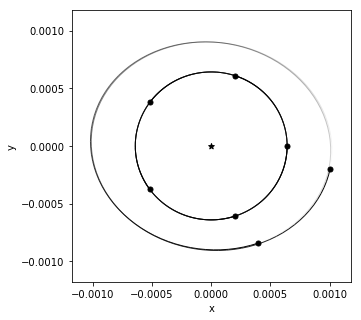

In [7]:
%matplotlib inline
sim = rebound.Simulation.from_file("../binaries/"+filename)
fig = rebound.OrbitPlot(sim)

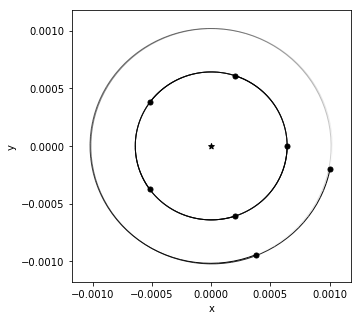

In [8]:
%matplotlib inline
sim = rebound.Simulation.from_file("../binaries/circular"+filename)
fig = rebound.OrbitPlot(sim)

## Add a ring of particles at Janus' 2:1 resonance, then Epimetheus and Janus

In [3]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "janus_ring.bin"
#try:
    #sim = rebound.Simulation.from_file("../binaries/"+filename)
#except:
date = "2017-06-04 05:00"
sim = rebound.Simulation()
sim.add("Saturn", date=date)
sim.add("Janus", date=date)
print('Janus a=',sim.particles[-1].a)
a_Janus=sim.particles[-1].a
theta_Janus=sim.particles[-1].theta
sim.remove(1)
N_ring=4
for i in range(1,N_ring):
    print(2.*np.pi/N_ring)
    sim.add(m=0.,a=a_Janus*2**(-2./3),theta=2.*np.pi/N_ring)
print('Janus 2:1 a=',sim.particles[-1].a)
sim.add("Epimetheus", date=date)
print('Epimetheus a=',sim.particles[-1].a)
sim.add("Janus", date=date)
print('Janus a=',sim.particles[-1].a)
sim.move_to_com()
sim.save("../binaries/"+filename)

Searching NASA Horizons for 'Saturn'... 

timeout: timed out

# Solar System

In [ ]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
filename = "solarsystem.bin"
#try:
    #sim = rebound.Simulation.from_file("../binaries/"+filename)
#except:
date = "1983-02-17 02:00"
sim = rebound.Simulation()
sim.add("Sun", date=date)
sim.add("Mercury", date=date)
sim.add("Venus", date=date)
sim.add("Earth", date=date)
sim.add("Mars", date=date)
sim.add("Jupiter", date=date)
sim.add("Saturn", date=date)
sim.add("Uranus", date=date)
sim.add("Neptune", date=date)
sim.move_to_com()
sim.save("../binaries/"+filename)

# Calculate Pitches

In [ ]:
notenames = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
A4 = 440
C0 = A4*pow(2, -4.75)
C4=C0*pow(2, 4)

def pitch(freq):
    h = int(round(12*np.log2(freq/C0)))
    octave = h // 12
    n = h % 12
    f0=C0*2**(h/12.)
    cent = 1200*np.log2(freq/f0)
    #return name[n] + str(octave) + ' + '+str(round(cent,1)) +' cents'
    return '{0} {1:+.1f} cents'.format(notenames[n]+str(octave),cent)

filename = "../binaries/newsystem.bin"
sim = rebound.Simulation.from_file(filename)

basefreq=C4 #or 1/timescle*2**octave
baseperiod=sim.particles[-1].P
freqs=[basefreq*baseperiod/sim.particles[i].P for i in range(1,sim.N)]

print('\nNotes and offsets:')
for i in range(1,sim.N):
    print('Planet '+str(i+1)+' : '+ pitch(freqs[i]),' = ',np.round(freqs[i],2), 'Hz')

Here we choose to add notes every time there is a transit or conjunction, so we add an `EventRecorder` for each of them. We choose to stagger planets in for the MIDI, so we initially set an empty list of target particles for finding the events, and update them later. 

In [6]:
transits = ss.EventRecorder(sim, lambda sim, i: sim.particles[i].y, targets=[])
conjunctions = ss.EventRecorder(sim, lambda sim, i: np.sin(sim.particles[i].theta - sim.particles[i+1].theta), targets=[])

We start by staggering in the planet transits, 4 outer planet orbits at a time, from the outside inward, by changing `transits.targets`.

In [7]:
planets = list(range(sim.N))
for i in range(1,8):
    ps = planets[-i:]
    transits.targets = ps
    print(transits.targets)
    sim.integrate(tmax=sim.t+4)

[7]
[6, 7]
[5, 6, 7]
[4, 5, 6, 7]
[3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7]


We now stagger in conjunctions starting from the outermost pair, leaving in all the planets for the transits:

In [8]:
planets = list(range(sim.N-1))
for i in range(1,7):
    ps = planets[-i:]
    conjunctions.targets = ps
    print(conjunctions.targets)
    sim.integrate(tmax=sim.t+4)

[6]
[5, 6]
[4, 5, 6]
[3, 4, 5, 6]
[2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6]


# Making the MIDI

We need to set a tempo in beats per minute, where 1 beat corresponds to one time unit in the simulation. Here we set bpm=30, which means that there are 2 seconds per simulation time unit = one outer planet orbit. We then make the MIDI file and set the tempo:

In [9]:
from midiutil import MIDIFile

bpm = 30
midifile = MIDIFile(adjust_origin=True)
midifile.addTempo(track=0, time=0, tempo=bpm) 

Now we need to decide on MIDI notes for the transits and conjunctions. We use the `calc_midi_notes` function to scale all notes relative to the outermost (ref_ID=-1) particle, and assign to that planet a MIDI note of 48=C4. See e.g.  http://subsynth.sourceforge.net/midinote2freq.html for a list of MIDI notes. We then manually assign notes to the conjunctions.

Finally, we step through the list of transits and conjunctions, and add the corresponding note for each of them, depending on the transiting planet or conjunction pair, at the time of the event. One can also set the note duration and velocity (volume). Here we add planet transits onto separate channels, and the conjunctions all into one channel above the others.

In [10]:
transit_notes = ss.calc_midi_notes(sim.particles, ref_note=48, ref_ID=-1)
conjunction_notes = [0, 33, 35, 20, 18, 14, 12]

for transit in transits.events:
    midifile.addNote(track=0, channel=transit['target'], pitch=transit_notes[transit['target']], time=transit['time'], duration=1, volume=100)
for conjunction in conjunctions.events:
    midifile.addNote(track=0, channel=sim.N, pitch=conjunction_notes[conjunction['target']], time=conjunction['time'], duration=1, volume=100)

Finally, we write the file:

In [11]:
with open("./trappist.mid", "wb") as f:
    midifile.writeFile(f)